
# Exercice 5: Self-Attention mechanism: Advanced Techniques

    Implement layer normalization before and after the attention mechanism. Compare the results of both approaches by visualizing the attention weights and outputs. Discuss the impact of layer normalization on the self-attention mechanism.
    


Phrase: Layer normalization stabilizes training dynamics
nb de mots: 5

embedding dim: 5
Input shape: (5, 5)
  Mean par token: [ 0.45900297  0.8742385  -2.59522995 -2.86495928 -0.66173024]
  Std par token: [0.63346215 1.46890455 2.46818176 2.32885043 4.71293108]
  Global mean: -0.9577
  Global std: 3.1002
  apres Attention - Mean: -0.1960, Std: 4.5111
  apres Add - Mean: -1.1537, Std: 5.4920
  apres LayerNorm - Mean: -0.0000, Std: 1.0000
  apres LayerNorm input - Mean: -0.0000, Std: 1.0000
  apres Attention - Mean: 0.1439, Std: 0.8076
  apres Add - Mean: -0.8138, Std: 3.2897


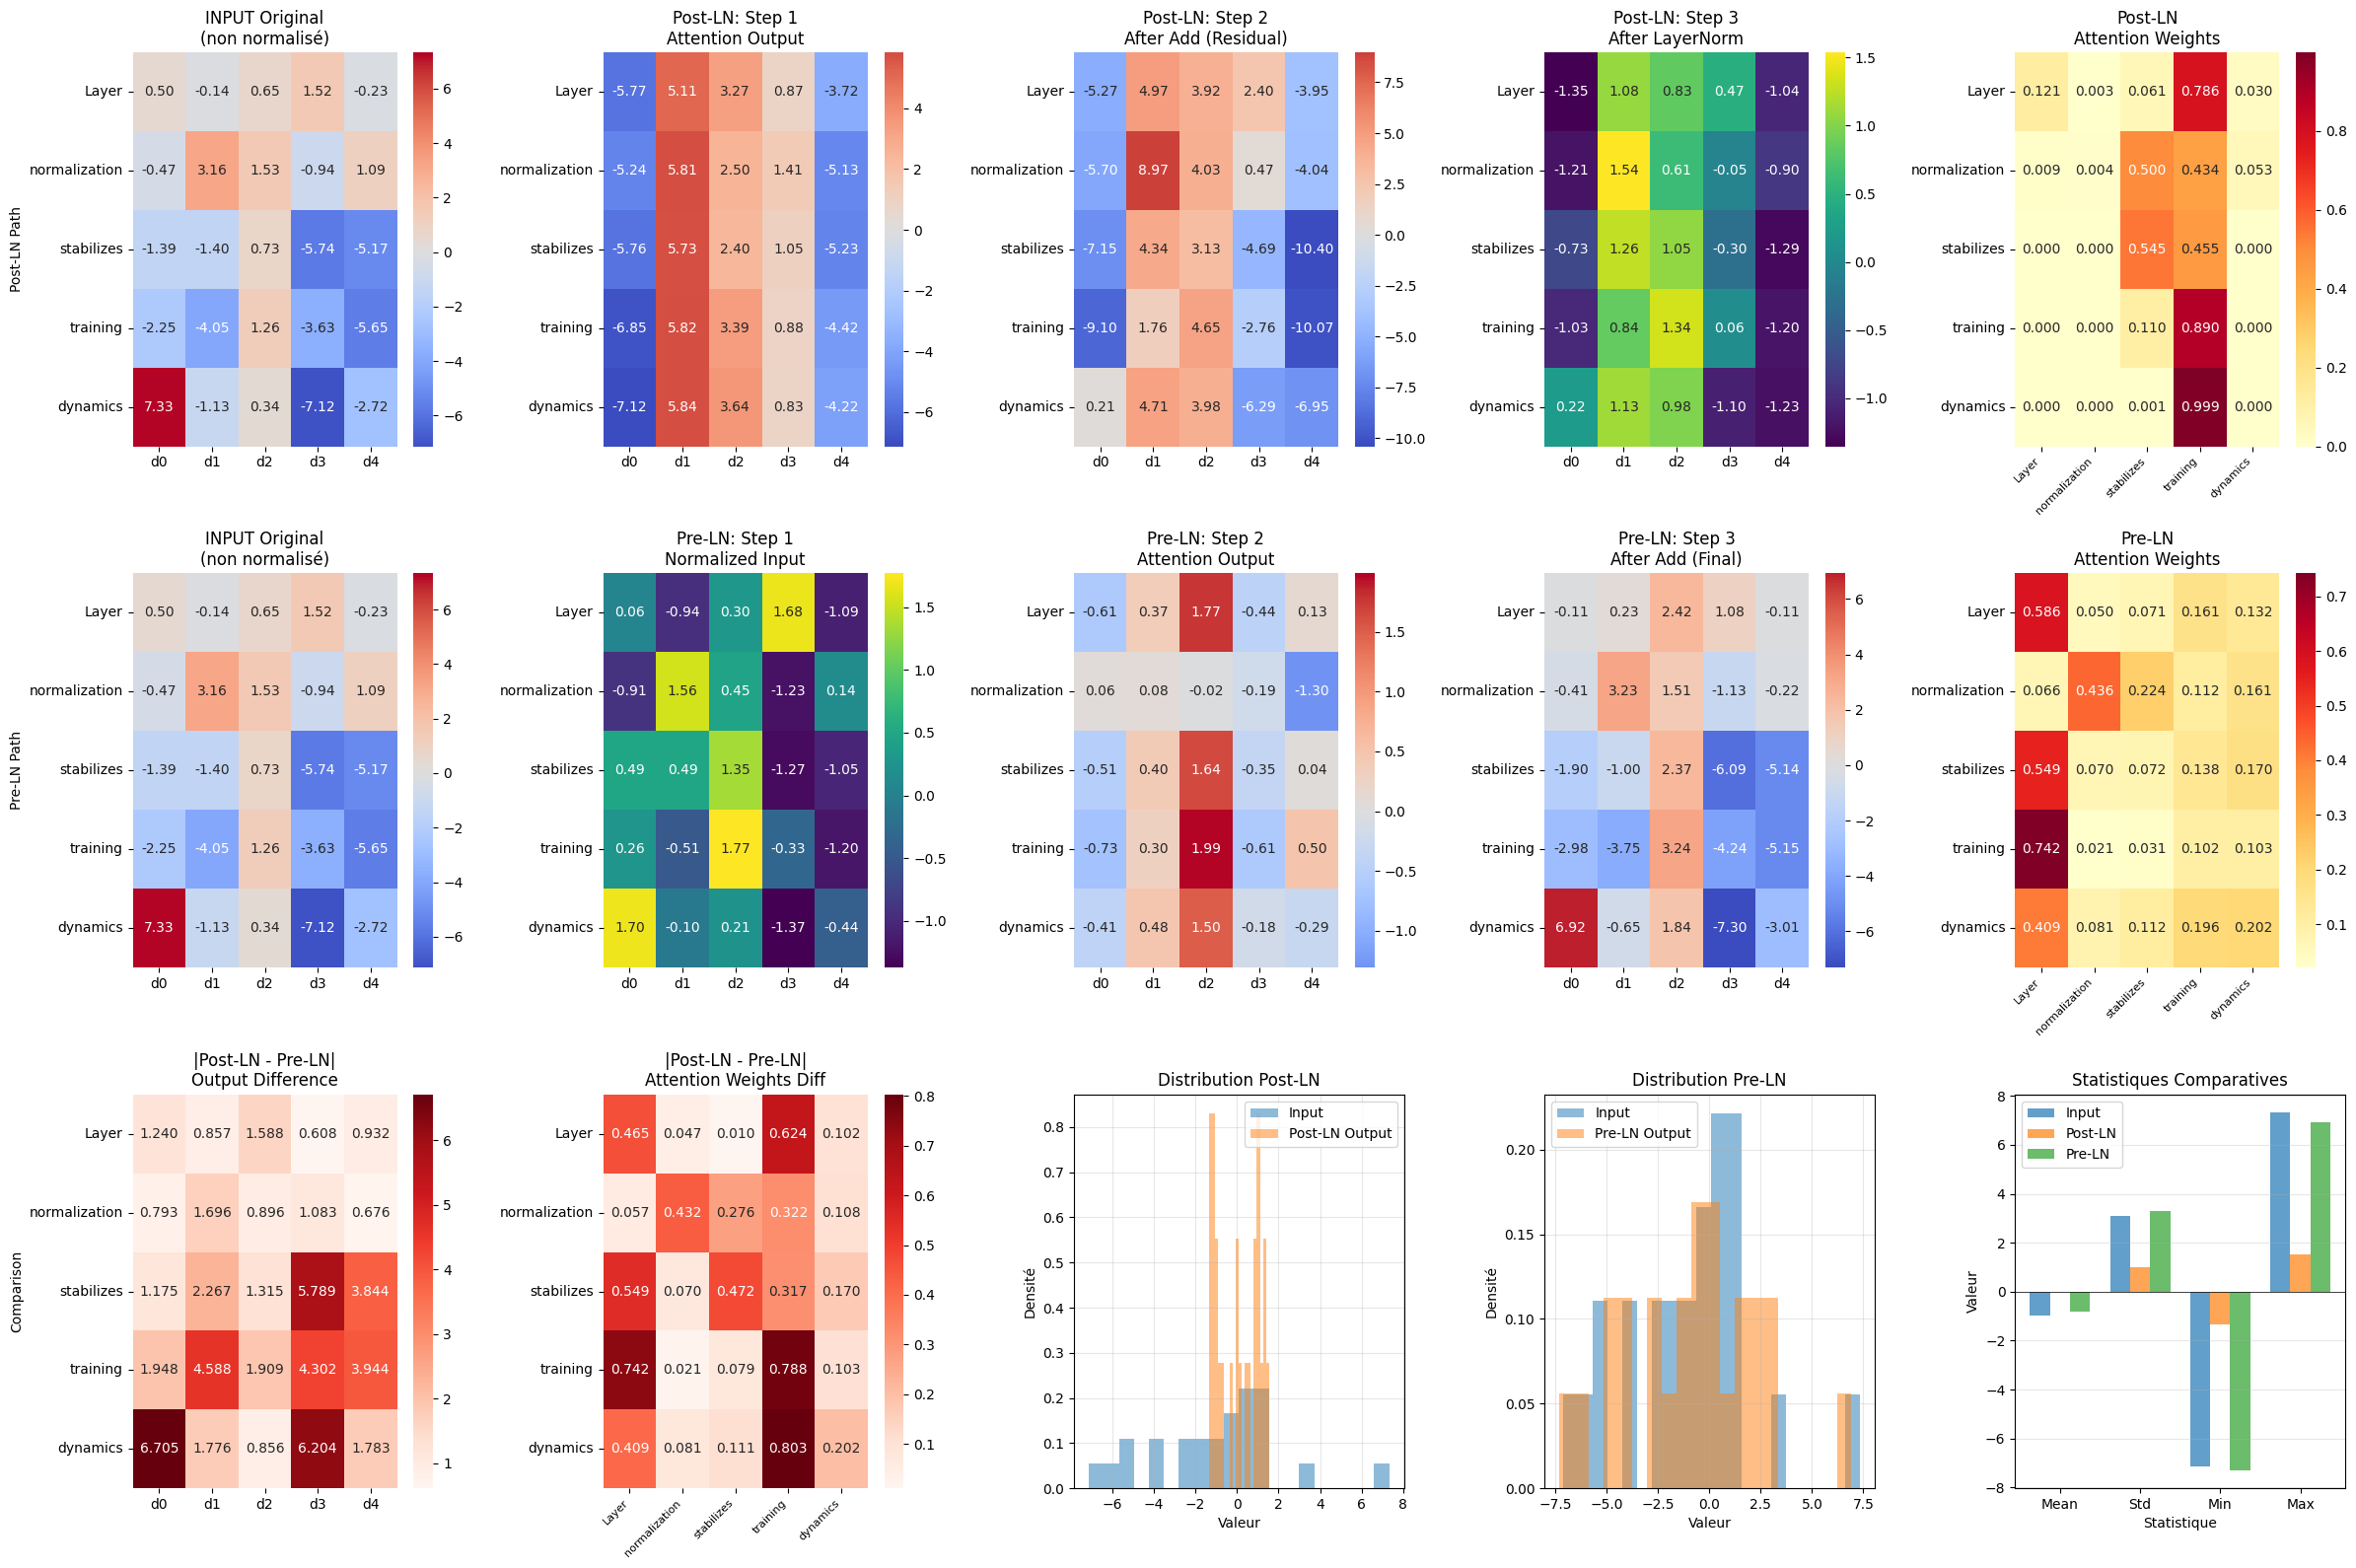


Approche        Mean         Std          Min          Max         
Input           -0.9577      3.1002       -7.1237      7.3282      
Post-LN         -0.0000      1.0000       -1.3518      1.5376      
Pre-LN          -0.8138      3.2897       -7.3016      6.9231      

Token           Input Std       Post-LN Std     Pre-LN Std     
Layer           0.6335          1.0000          0.9637         
normalization   1.4689          1.0000          1.5791         
stabilizes      2.4682          1.0000          3.0344         
training        2.3289          1.0000          2.9933         
dynamics        4.7129          1.0000          4.7570         


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)

def layer_norm(x, eps=1e-6):

    mean = np.mean(x, axis=-1, keepdims=True)
    std = np.std(x, axis=-1, keepdims=True)
    return (x - mean) / (std + eps)

def compute_attention(inputs, embedding_dim):
    np.random.seed(42)
    limit = np.sqrt(6.0 / (embedding_dim + embedding_dim))
    Wq = np.random.uniform(-limit, limit, (embedding_dim, embedding_dim))
    Wk = np.random.uniform(-limit, limit, (embedding_dim, embedding_dim))
    Wv = np.random.uniform(-limit, limit, (embedding_dim, embedding_dim))
    
    Q = np.dot(inputs, Wq)
    K = np.dot(inputs, Wk)
    V = np.dot(inputs, Wv)
    
    
    scores = np.dot(Q, K.T) / np.sqrt(K.shape[1])
    attention_weights = softmax(scores)
    attention_output = np.dot(attention_weights, V)
    
    return attention_output, attention_weights

def post_layer_norm_block(inputs, embedding_dim):
    
    attention_output, attention_weights = compute_attention(inputs, embedding_dim)
    
    add_output = attention_output + inputs
    
    norm_output = layer_norm(add_output)
    
    return norm_output, attention_output, add_output, attention_weights

def pre_layer_norm_block(inputs, embedding_dim):
  
    norm_input = layer_norm(inputs)
    
    attention_output, attention_weights = compute_attention(norm_input, embedding_dim)
    
    add_output = attention_output + inputs
    
    return add_output, norm_input, attention_output, attention_weights

sentence = ["Layer", "normalization", "stabilizes", "training", "dynamics"]


print(f"\nPhrase: {' '.join(sentence)}")
print(f"nb de mots: {len(sentence)}")

embedding_dim = 5
np.random.seed(42)
embeddings = {}
for i, word in enumerate(sentence):
    embeddings[word] = np.random.randn(embedding_dim) * (i + 1)

inputs = np.array([embeddings[word] for word in sentence])

print(f"\nembedding dim: {embedding_dim}")
print(f"Input shape: {inputs.shape}")
print(f"  Mean par token: {np.mean(inputs, axis=1)}")
print(f"  Std par token: {np.std(inputs, axis=1)}")
print(f"  Global mean: {np.mean(inputs):.4f}")
print(f"  Global std: {np.std(inputs):.4f}")



output_post, attn_out_post, add_out_post, weights_post = post_layer_norm_block(inputs, embedding_dim)

print(f"  apres Attention - Mean: {np.mean(attn_out_post):.4f}, Std: {np.std(attn_out_post):.4f}")
print(f"  apres Add - Mean: {np.mean(add_out_post):.4f}, Std: {np.std(add_out_post):.4f}")
print(f"  apres LayerNorm - Mean: {np.mean(output_post):.4f}, Std: {np.std(output_post):.4f}")



output_pre, norm_in_pre, attn_out_pre, weights_pre = pre_layer_norm_block(inputs, embedding_dim)

print(f"  apres LayerNorm input - Mean: {np.mean(norm_in_pre):.4f}, Std: {np.std(norm_in_pre):.4f}")
print(f"  apres Attention - Mean: {np.mean(attn_out_pre):.4f}, Std: {np.std(attn_out_pre):.4f}")
print(f"  apres Add - Mean: {np.mean(output_pre):.4f}, Std: {np.std(output_pre):.4f}")


fig = plt.figure(figsize=(24, 16))

plt.subplot(3, 5, 1)
sns.heatmap(inputs, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            xticklabels=[f'd{i}' for i in range(embedding_dim)],
            yticklabels=sentence)
plt.title('INPUT Original\n(non normalisé)')
plt.ylabel('Post-LN Path')

plt.subplot(3, 5, 2)
sns.heatmap(attn_out_post, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            xticklabels=[f'd{i}' for i in range(embedding_dim)],
            yticklabels=sentence)
plt.title('Post-LN: Step 1\nAttention Output')

plt.subplot(3, 5, 3)
sns.heatmap(add_out_post, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            xticklabels=[f'd{i}' for i in range(embedding_dim)],
            yticklabels=sentence)
plt.title('Post-LN: Step 2\nAfter Add (Residual)')

plt.subplot(3, 5, 4)
sns.heatmap(output_post, annot=True, fmt='.2f', cmap='viridis',
            xticklabels=[f'd{i}' for i in range(embedding_dim)],
            yticklabels=sentence)
plt.title('Post-LN: Step 3\nAfter LayerNorm')

plt.subplot(3, 5, 5)
sns.heatmap(weights_post, annot=True, fmt='.3f', cmap='YlOrRd',
            xticklabels=sentence, yticklabels=sentence)
plt.title('Post-LN\nAttention Weights')
plt.xticks(rotation=45, ha='right', fontsize=8)

plt.subplot(3, 5, 6)
sns.heatmap(inputs, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            xticklabels=[f'd{i}' for i in range(embedding_dim)],
            yticklabels=sentence)
plt.title('INPUT Original\n(non normalisé)')
plt.ylabel('Pre-LN Path')

plt.subplot(3, 5, 7)
sns.heatmap(norm_in_pre, annot=True, fmt='.2f', cmap='viridis',
            xticklabels=[f'd{i}' for i in range(embedding_dim)],
            yticklabels=sentence)
plt.title('Pre-LN: Step 1\nNormalized Input')

plt.subplot(3, 5, 8)
sns.heatmap(attn_out_pre, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            xticklabels=[f'd{i}' for i in range(embedding_dim)],
            yticklabels=sentence)
plt.title('Pre-LN: Step 2\nAttention Output')

plt.subplot(3, 5, 9)
sns.heatmap(output_pre, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            xticklabels=[f'd{i}' for i in range(embedding_dim)],
            yticklabels=sentence)
plt.title('Pre-LN: Step 3\nAfter Add (Final)')

plt.subplot(3, 5, 10)
sns.heatmap(weights_pre, annot=True, fmt='.3f', cmap='YlOrRd',
            xticklabels=sentence, yticklabels=sentence)
plt.title('Pre-LN\nAttention Weights')
plt.xticks(rotation=45, ha='right', fontsize=8)

plt.subplot(3, 5, 11)
diff_output = np.abs(output_post - output_pre)
sns.heatmap(diff_output, annot=True, fmt='.3f', cmap='Reds',
            xticklabels=[f'd{i}' for i in range(embedding_dim)],
            yticklabels=sentence)
plt.title('|Post-LN - Pre-LN|\nOutput Difference')
plt.ylabel('Comparison')

plt.subplot(3, 5, 12)
diff_weights = np.abs(weights_post - weights_pre)
sns.heatmap(diff_weights, annot=True, fmt='.3f', cmap='Reds',
            xticklabels=sentence, yticklabels=sentence)
plt.title('|Post-LN - Pre-LN|\nAttention Weights Diff')
plt.xticks(rotation=45, ha='right', fontsize=8)

plt.subplot(3, 5, 13)
plt.hist(inputs.flatten(), bins=20, alpha=0.5, label='Input', density=True)
plt.hist(output_post.flatten(), bins=20, alpha=0.5, label='Post-LN Output', density=True)
plt.xlabel('Valeur')
plt.ylabel('Densité')
plt.title('Distribution Post-LN')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 5, 14)
plt.hist(inputs.flatten(), bins=20, alpha=0.5, label='Input', density=True)
plt.hist(output_pre.flatten(), bins=20, alpha=0.5, label='Pre-LN Output', density=True)
plt.xlabel('Valeur')
plt.ylabel('Densité')
plt.title('Distribution Pre-LN')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 5, 15)
stats_comparison = {
    'Input': [np.mean(inputs), np.std(inputs), np.min(inputs), np.max(inputs)],
    'Post-LN': [np.mean(output_post), np.std(output_post), np.min(output_post), np.max(output_post)],
    'Pre-LN': [np.mean(output_pre), np.std(output_pre), np.min(output_pre), np.max(output_pre)]
}
x = np.arange(4)
width = 0.25
labels = ['Mean', 'Std', 'Min', 'Max']
plt.bar(x - width, stats_comparison['Input'], width, label='Input', alpha=0.7)
plt.bar(x, stats_comparison['Post-LN'], width, label='Post-LN', alpha=0.7)
plt.bar(x + width, stats_comparison['Pre-LN'], width, label='Pre-LN', alpha=0.7)
plt.xlabel('Statistique')
plt.ylabel('Valeur')
plt.title('Statistiques Comparatives')
plt.xticks(x, labels)
plt.legend()
plt.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
plt.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()



print(f"\n{'Approche':<15} {'Mean':<12} {'Std':<12} {'Min':<12} {'Max':<12}")
print(f"{'Input':<15} {np.mean(inputs):<12.4f} {np.std(inputs):<12.4f} {np.min(inputs):<12.4f} {np.max(inputs):<12.4f}")
print(f"{'Post-LN':<15} {np.mean(output_post):<12.4f} {np.std(output_post):<12.4f} {np.min(output_post):<12.4f} {np.max(output_post):<12.4f}")
print(f"{'Pre-LN':<15} {np.mean(output_pre):<12.4f} {np.std(output_pre):<12.4f} {np.min(output_pre):<12.4f} {np.max(output_pre):<12.4f}")

print(f"\n{'Token':<15} {'Input Std':<15} {'Post-LN Std':<15} {'Pre-LN Std':<15}")
for i, word in enumerate(sentence):
    input_std = np.std(inputs[i])
    post_std = np.std(output_post[i])
    pre_std = np.std(output_pre[i])
    print(f"{word:<15} {input_std:<15.4f} {post_std:<15.4f} {pre_std:<15.4f}")



Post-LN  montre des activations plus extrêmes avant la normalisation, ce qui peut entraîner une instabilité numérique

Pre-LN  applique la normalisation avant les opérations principales, ce qui stabilise les valeurs 

Les différences  indiquent que Post-LN produit des sorties plus dispersées, tandis que Pre-LN garde des activations plus homogènes

Post-LN a une variance plus grande

 Pre-LN est plus resserré autour de zéro.



Pre-LN offre une meilleure stabilité d’entraînement et des gradients plus réguliers, tandis que Post-LN peut donner des activations plus dynamiques mais moins stables.

2) Experiment with different activation functions in the feed-forward layer following the attention mechanism. Replace ReLU with other functions (e.g., Leaky ReLU, ELU). Compute and visualize the attention outputs for each activation function and compare the results.
    


Phrase: Activation functions introduce non linearity
nb  mots: 5

Embedding dimension: 5
FFN intermediate dimension: 20
Input shape: (5, 5)

Statistiques FFN intermediate (avant activation):
  Mean: -0.0162
  Std: 0.2064
  Min: -0.4515
  Max: 0.5335
  % négatifs: 57.0%

Statistiques FFN activated (après ReLU):
  Mean: 0.0714
  Std: 0.1247
  Min: 0.0000
  Max: 0.5335
  % zéros: 57.0%

Statistiques FFN intermediate (avant activation):
  Mean: -0.0162
  Std: 0.2064
  Min: -0.4515
  Max: 0.5335
  % négatifs: 57.0%

Statistiques FFN activated (après Leaky ReLU):
  Mean: 0.0705
  Std: 0.1252
  Min: -0.0045
  Max: 0.5335
  % zéros: 0.0%

Statistiques FFN intermediate (avant activation):
  Mean: -0.0162
  Std: 0.2064
  Min: -0.4515
  Max: 0.5335
  % négatifs: 57.0%

Statistiques FFN activated (après ELU):
  Mean: -0.0061
  Std: 0.1927
  Min: -0.3633
  Max: 0.5335
  % zéros: 0.0%

Statistiques FFN intermediate (avant activation):
  Mean: -0.0162
  Std: 0.2064
  Min: -0.4515
  Max: 0.5335
  % n

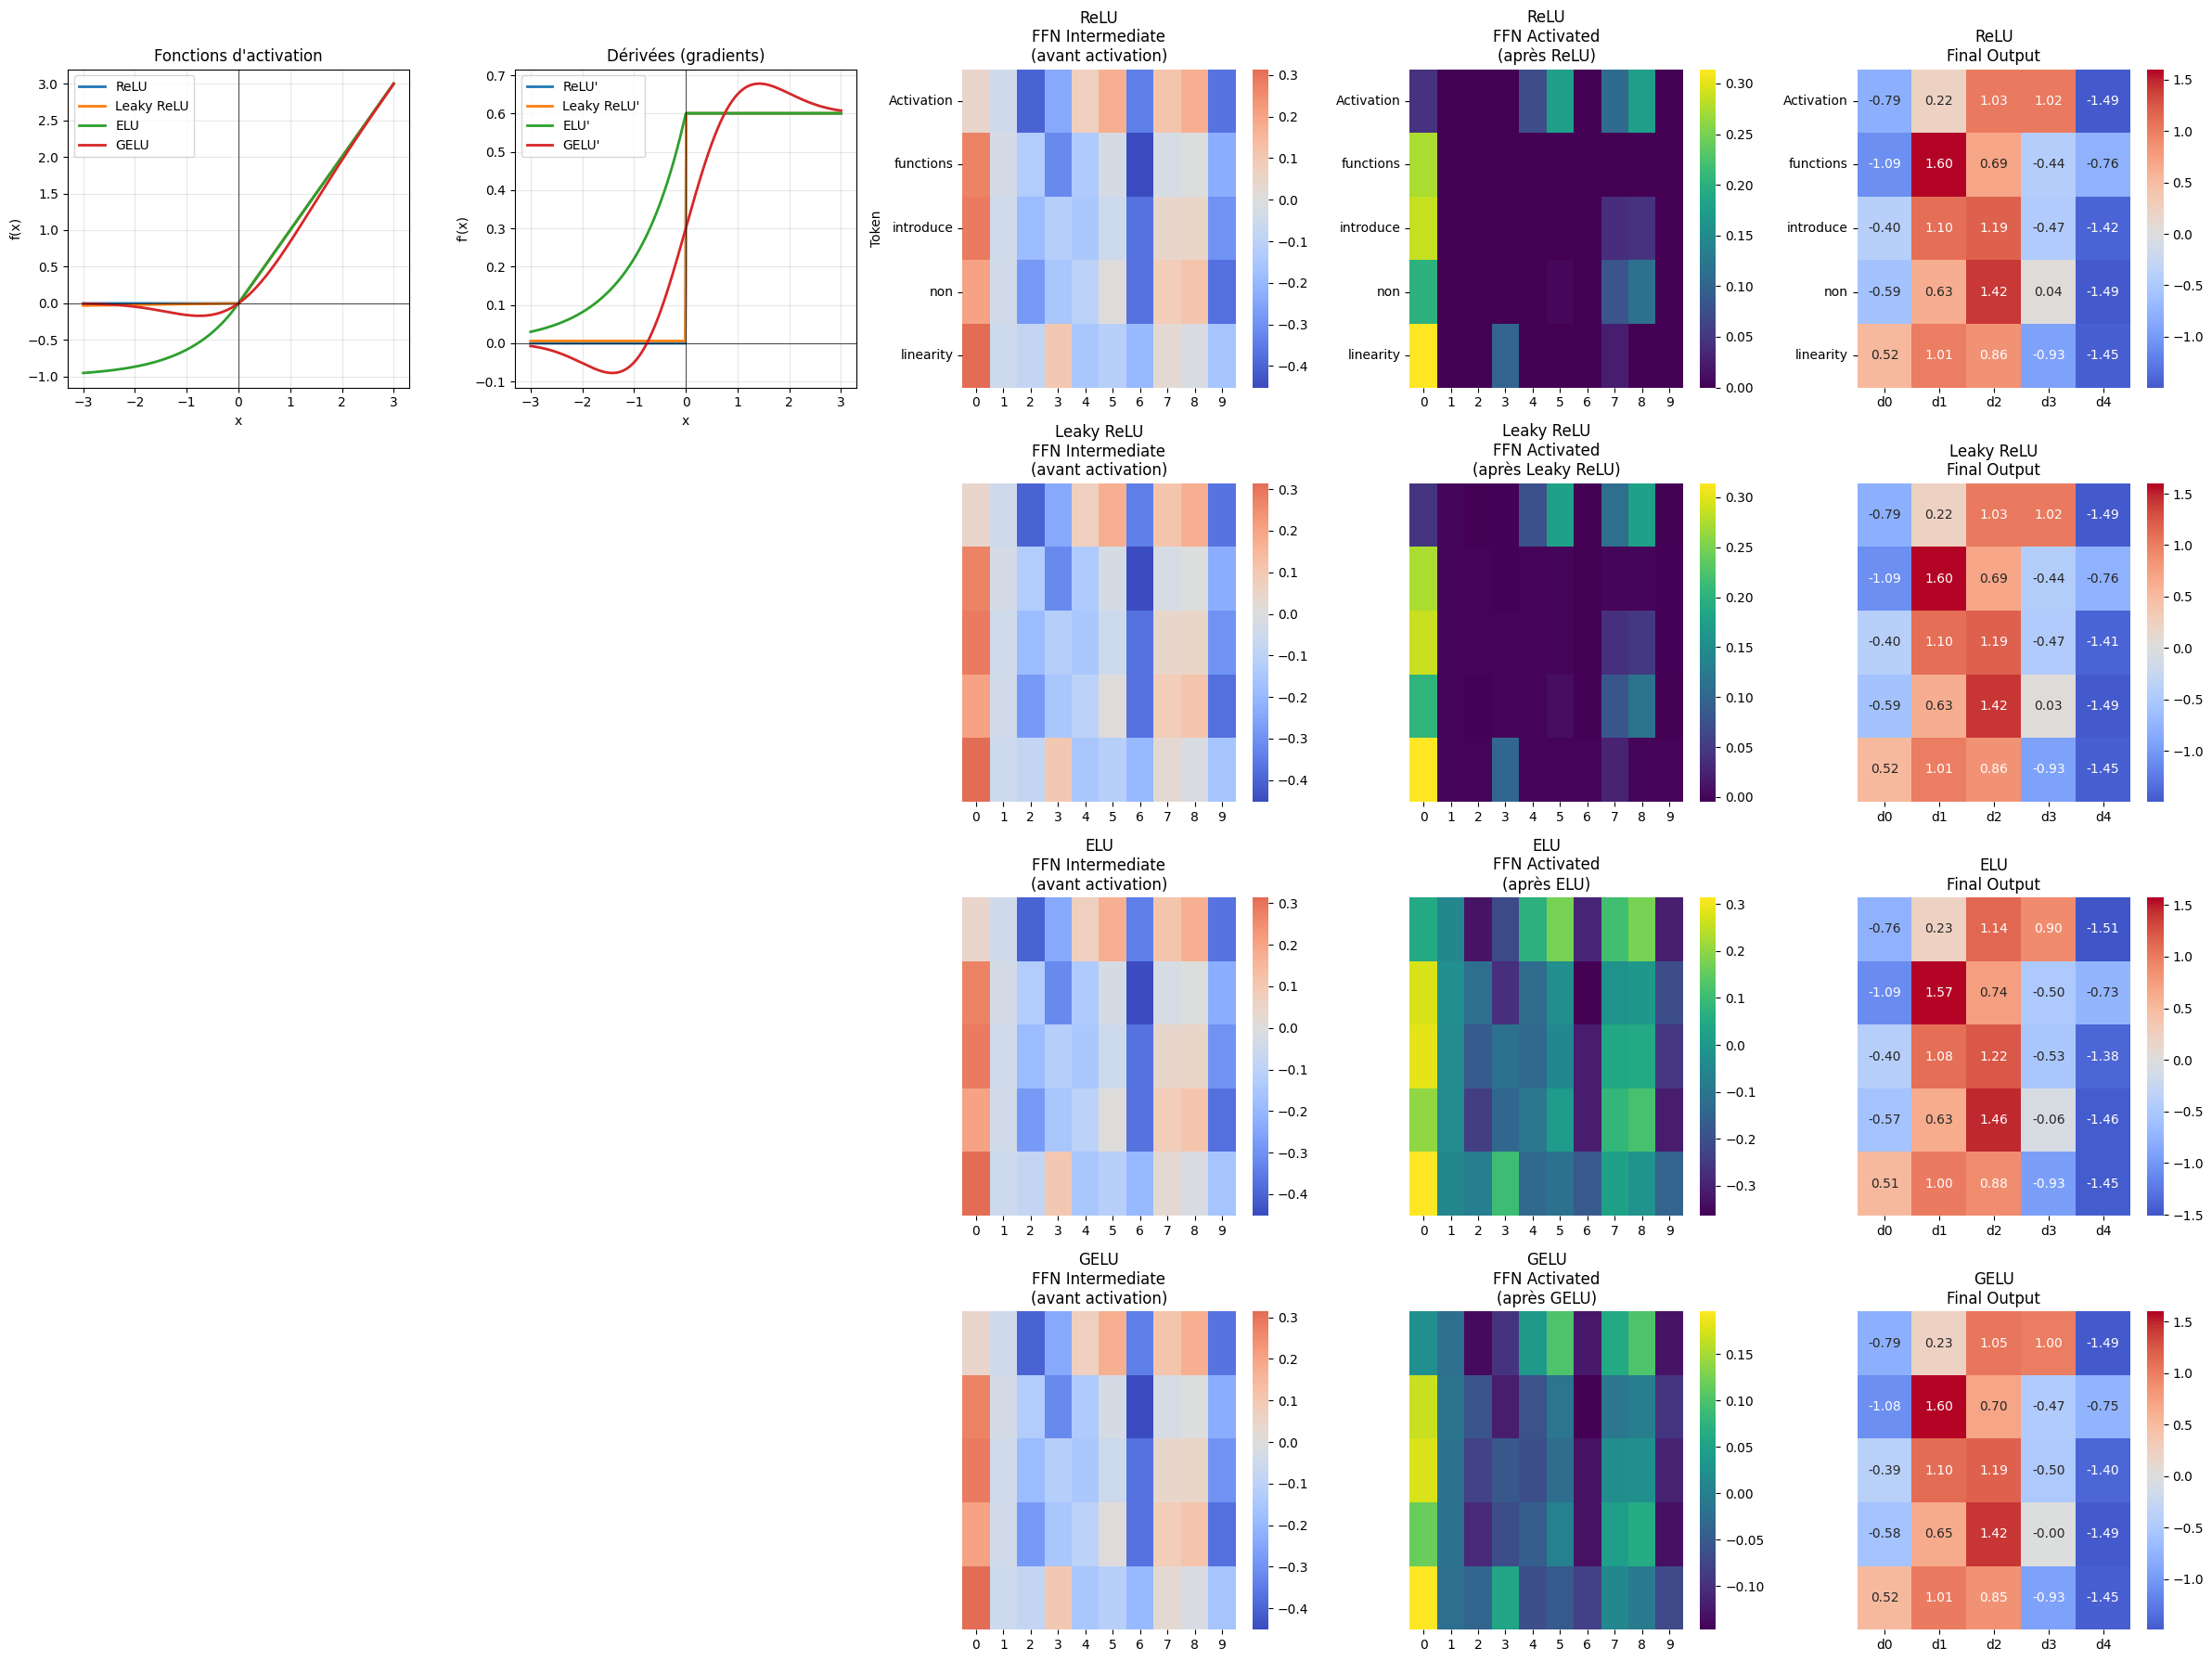

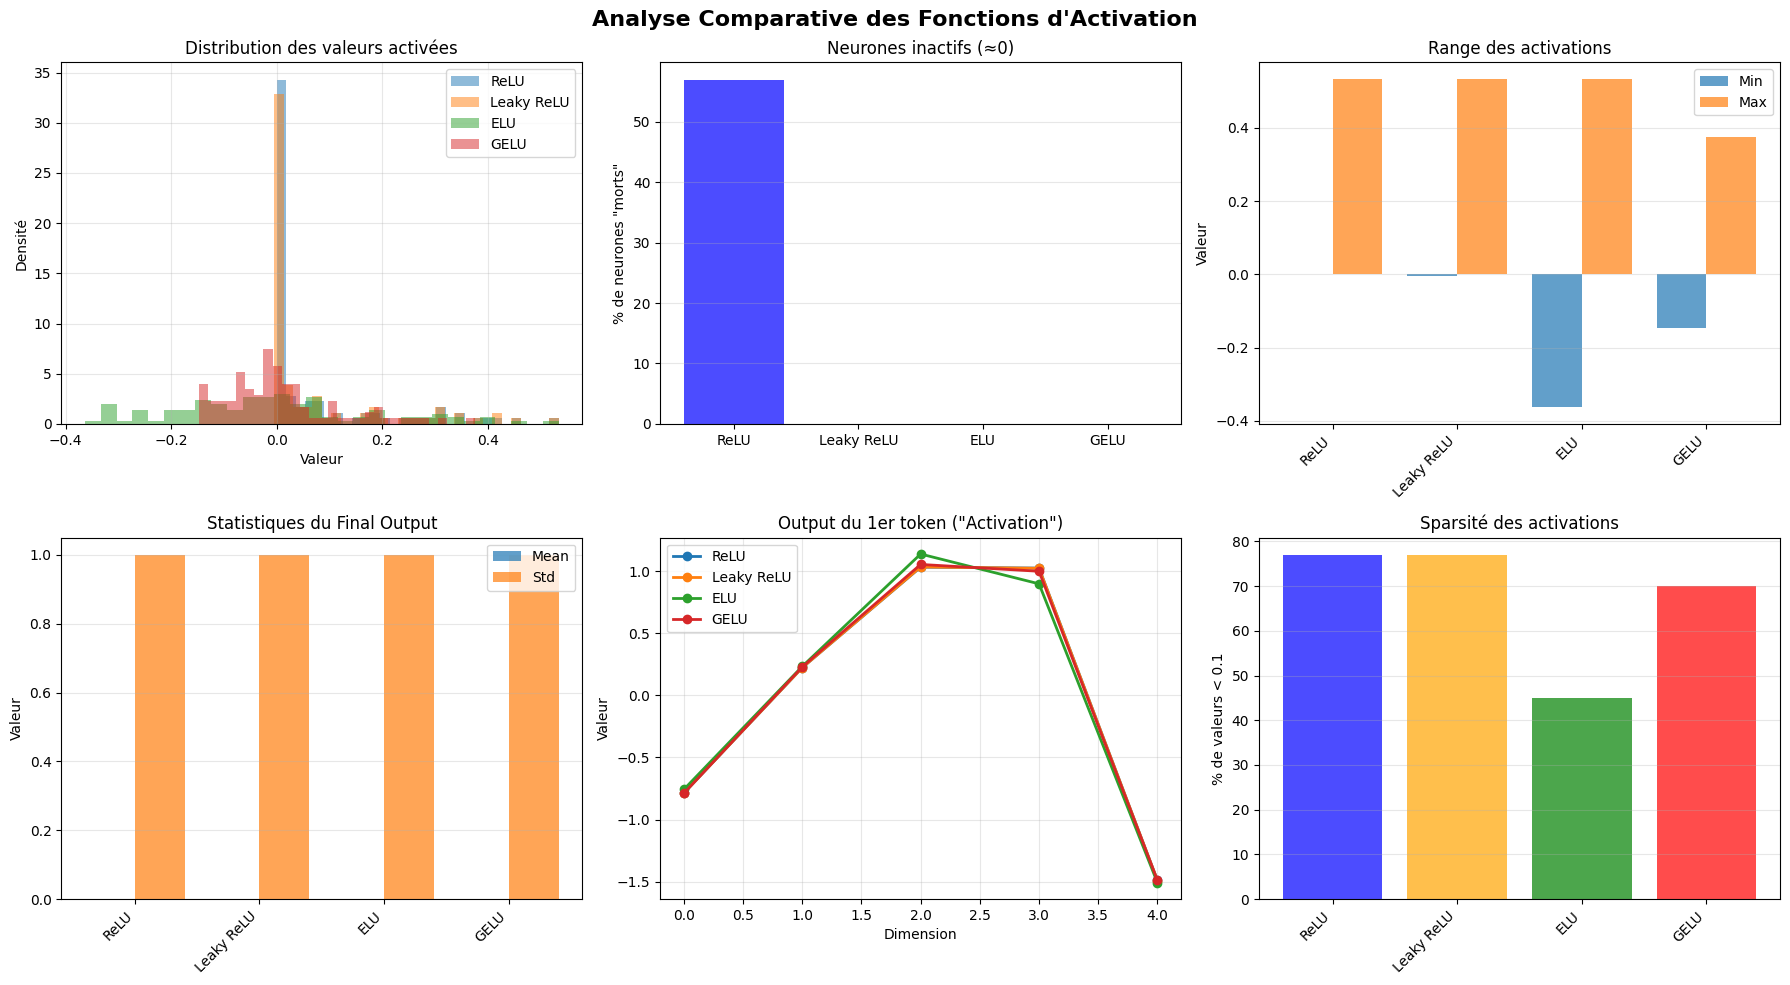


Activation      Mean       Std        Min        Max        % Morts   
---------------------------------------------------------------------------
ReLU            0.0714     0.1247     0.0000     0.5335     57.0      
Leaky ReLU      0.0705     0.1252     -0.0045    0.5335     0.0       
ELU             -0.0061    0.1927     -0.3633    0.5335     0.0       
GELU            0.0087     0.1076     -0.1471    0.3751     0.0       


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)

def layer_norm(x, eps=1e-6):
    mean = np.mean(x, axis=-1, keepdims=True)
    std = np.std(x, axis=-1, keepdims=True)
    return (x - mean) / (std + eps)


def relu(x):
    return np.maximum(0, x)

def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def elu(x, alpha=1.0):
    return np.where(x > 0, x, alpha * (np.exp(x) - 1))

def gelu(x):
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * x**3)))

def compute_attention_with_ffn(inputs, embedding_dim, activation_fn, activation_name):
    
    np.random.seed(42)
    limit = np.sqrt(6.0 / (embedding_dim + embedding_dim))
    Wq = np.random.uniform(-limit, limit, (embedding_dim, embedding_dim))
    Wk = np.random.uniform(-limit, limit, (embedding_dim, embedding_dim))
    Wv = np.random.uniform(-limit, limit, (embedding_dim, embedding_dim))
    
    Q = np.dot(inputs, Wq)
    K = np.dot(inputs, Wk)
    V = np.dot(inputs, Wv)
    
    scores = np.dot(Q, K.T) / np.sqrt(K.shape[1])
    attention_weights = softmax(scores)
    attention_output = np.dot(attention_weights, V)
    
    attention_output_norm = layer_norm(attention_output + inputs)
    
    d_ff = embedding_dim * 4  
    
    np.random.seed(42)
    W1 = np.random.randn(embedding_dim, d_ff) * 0.1
    b1 = np.zeros(d_ff)
    W2 = np.random.randn(d_ff, embedding_dim) * 0.1
    b2 = np.zeros(embedding_dim)
    
    ffn_intermediate = np.dot(attention_output_norm, W1) + b1
    ffn_activated = activation_fn(ffn_intermediate)
    
    ffn_output = np.dot(ffn_activated, W2) + b2
    
    final_output = layer_norm(ffn_output + attention_output_norm)
    
    return {
        'attention_weights': attention_weights,
        'attention_output': attention_output,
        'attention_output_norm': attention_output_norm,
        'ffn_intermediate': ffn_intermediate,
        'ffn_activated': ffn_activated,
        'ffn_output': ffn_output,
        'final_output': final_output
    }

sentence = ["Activation", "functions", "introduce", "non", "linearity"]


print(f"\nPhrase: {' '.join(sentence)}")
print(f"nb  mots: {len(sentence)}")

embedding_dim = 5
np.random.seed(42)
embeddings = {word: np.random.randn(embedding_dim) for word in sentence}
inputs = np.array([embeddings[word] for word in sentence])

print(f"\nEmbedding dimension: {embedding_dim}")
print(f"FFN intermediate dimension: {embedding_dim * 4}")
print(f"Input shape: {inputs.shape}")

activations = {
    'ReLU': relu,
    'Leaky ReLU': lambda x: leaky_relu(x, alpha=0.01),
    'ELU': lambda x: elu(x, alpha=1.0),
    'GELU': gelu
}

results = {}

for name, activation_fn in activations.items():

    result = compute_attention_with_ffn(inputs, embedding_dim, activation_fn, name)
    results[name] = result
    
    print(f"\nStatistiques FFN intermediate (avant activation):")
    print(f"  Mean: {np.mean(result['ffn_intermediate']):.4f}")
    print(f"  Std: {np.std(result['ffn_intermediate']):.4f}")
    print(f"  Min: {np.min(result['ffn_intermediate']):.4f}")
    print(f"  Max: {np.max(result['ffn_intermediate']):.4f}")
    print(f"  % négatifs: {np.sum(result['ffn_intermediate'] < 0) / result['ffn_intermediate'].size * 100:.1f}%")
    
    print(f"\nStatistiques FFN activated (après {name}):")
    print(f"  Mean: {np.mean(result['ffn_activated']):.4f}")
    print(f"  Std: {np.std(result['ffn_activated']):.4f}")
    print(f"  Min: {np.min(result['ffn_activated']):.4f}")
    print(f"  Max: {np.max(result['ffn_activated']):.4f}")
    print(f"  % zéros: {np.sum(result['ffn_activated'] == 0) / result['ffn_activated'].size * 100:.1f}%")

fig = plt.figure(figsize=(24, 18))

plt.subplot(4, 5, 1)
x = np.linspace(-3, 3, 1000)
for name, activation_fn in activations.items():
    y = activation_fn(x)
    plt.plot(x, y, label=name, linewidth=2)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Fonctions d\'activation')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
plt.axvline(x=0, color='k', linestyle='-', linewidth=0.5)

plt.subplot(4, 5, 2)
dx = 0.01
for name, activation_fn in activations.items():
    y = activation_fn(x)
    dy = np.gradient(y, dx)
    plt.plot(x, dy, label=f"{name}'", linewidth=2)
plt.xlabel('x')
plt.ylabel("f'(x)")
plt.title('Dérivées (gradients)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
plt.axvline(x=0, color='k', linestyle='-', linewidth=0.5)

row = 0
for name in activations.keys():
    result = results[name]
    
    plt.subplot(4, 5, row*5 + 3)
    sns.heatmap(result['ffn_intermediate'][:, :10], annot=False, cmap='coolwarm', center=0,
                yticklabels=sentence if row == 0 else [])
    plt.title(f'{name}\nFFN Intermediate\n(avant activation)')
    if row == 0:
        plt.ylabel('Token')
    
    plt.subplot(4, 5, row*5 + 4)
    sns.heatmap(result['ffn_activated'][:, :10], annot=False, cmap='viridis',
                yticklabels=sentence if row == 0 else [])
    plt.title(f'{name}\nFFN Activated\n(après {name})')
    
    plt.subplot(4, 5, row*5 + 5)
    sns.heatmap(result['final_output'], annot=True, fmt='.2f', cmap='coolwarm', center=0,
                xticklabels=[f'd{i}' for i in range(embedding_dim)],
                yticklabels=sentence if row == 0 else [])
    plt.title(f'{name}\nFinal Output')
    
    row += 1

plt.tight_layout()
plt.show()

fig2, axes = plt.subplots(2, 3, figsize=(18, 10))
fig2.suptitle('Analyse Comparative des Fonctions d\'Activation', fontsize=16, fontweight='bold')

ax = axes[0, 0]
for name in activations.keys():
    activated = results[name]['ffn_activated'].flatten()
    ax.hist(activated, bins=30, alpha=0.5, label=name, density=True)
ax.set_xlabel('Valeur')
ax.set_ylabel('Densité')
ax.set_title('Distribution des valeurs activées')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[0, 1]
dead_neurons = []
for name in activations.keys():
    activated = results[name]['ffn_activated']
    dead = np.sum(np.abs(activated) < 1e-6) / activated.size * 100
    dead_neurons.append(dead)
ax.bar(activations.keys(), dead_neurons, color=['blue', 'orange', 'green', 'red'], alpha=0.7)
ax.set_ylabel('% de neurones "morts"')
ax.set_title('Neurones inactifs (≈0)')
ax.grid(True, axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')

ax = axes[0, 2]
x_pos = np.arange(len(activations))
mins = [np.min(results[name]['ffn_activated']) for name in activations.keys()]
maxs = [np.max(results[name]['ffn_activated']) for name in activations.keys()]
ax.bar(x_pos - 0.2, mins, 0.4, label='Min', alpha=0.7)
ax.bar(x_pos + 0.2, maxs, 0.4, label='Max', alpha=0.7)
ax.set_ylabel('Valeur')
ax.set_title('Range des activations')
ax.set_xticks(x_pos)
ax.set_xticklabels(activations.keys(), rotation=45, ha='right')
ax.legend()
ax.grid(True, axis='y', alpha=0.3)



ax = axes[1, 0]
means = [np.mean(results[name]['final_output']) for name in activations.keys()]
stds = [np.std(results[name]['final_output']) for name in activations.keys()]
x_pos = np.arange(len(activations))
ax.bar(x_pos - 0.2, means, 0.4, label='Mean', alpha=0.7)
ax.bar(x_pos + 0.2, stds, 0.4, label='Std', alpha=0.7)
ax.set_ylabel('Valeur')
ax.set_title('Statistiques du Final Output')
ax.set_xticks(x_pos)
ax.set_xticklabels(activations.keys(), rotation=45, ha='right')
ax.legend()
ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
ax.grid(True, axis='y', alpha=0.3)



ax = axes[1, 1]
for name in activations.keys():
    output = results[name]['final_output'][0, :]
    ax.plot(output, marker='o', label=name, linewidth=2)
ax.set_xlabel('Dimension')
ax.set_ylabel('Valeur')
ax.set_title(f'Output du 1er token ("{sentence[0]}")')
ax.legend()
ax.grid(True, alpha=0.3)



ax = axes[1, 2]
sparsities = []
for name in activations.keys():
    activated = results[name]['ffn_activated']
    sparse = np.sum(np.abs(activated) < 0.1) / activated.size * 100
    sparsities.append(sparse)
ax.bar(activations.keys(), sparsities, color=['blue', 'orange', 'green', 'red'], alpha=0.7)
ax.set_ylabel('% de valeurs < 0.1')
ax.set_title('Sparsité des activations')
ax.grid(True, axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


print(f"\n{'Activation':<15} {'Mean':<10} {'Std':<10} {'Min':<10} {'Max':<10} {'% Morts':<10}")
print("-" * 75)

for name in activations.keys():
    activated = results[name]['ffn_activated']
    mean_val = np.mean(activated)
    std_val = np.std(activated)
    min_val = np.min(activated)
    max_val = np.max(activated)
    dead_pct = np.sum(np.abs(activated) < 1e-6) / activated.size * 100
    
    print(f"{name:<15} {mean_val:<10.4f} {std_val:<10.4f} {min_val:<10.4f} {max_val:<10.4f} {dead_pct:<10.1f}")




ReLU  pour la rapidité

GELU  pour la stabilité et les performances dans les architectures modernes comme Transformers

3) Implement a mechanism to handle variable-length sequences using masking. Compute the attention scores and apply the mask to ignore padding tokens. Visualize the attention weights and outputs with and without masking and discuss the differences.



  Séquence 1 (longueur=2): ['Hello', 'world', '<PAD>', '<PAD>']
  Séquence 2 (longueur=4): ['Machine', 'learning', 'is', 'amazing']
  Séquence 3 (longueur=1): ['AI', '<PAD>', '<PAD>', '<PAD>']
[[1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [1. 0. 0. 0.]]
\ décodeur: ['Start', 'I', 'love', 'AI']
\masque  look-ahead (1=peut voir, 0=ne peut pas voir):
[[1 0 0 0]
 [1 1 0 0]
 [1 1 1 0]
 [1 1 1 1]]


/tmp/ipykernel_47964/1184214877.py:6: RuntimeWarning: invalid value encountered in divide
  return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)


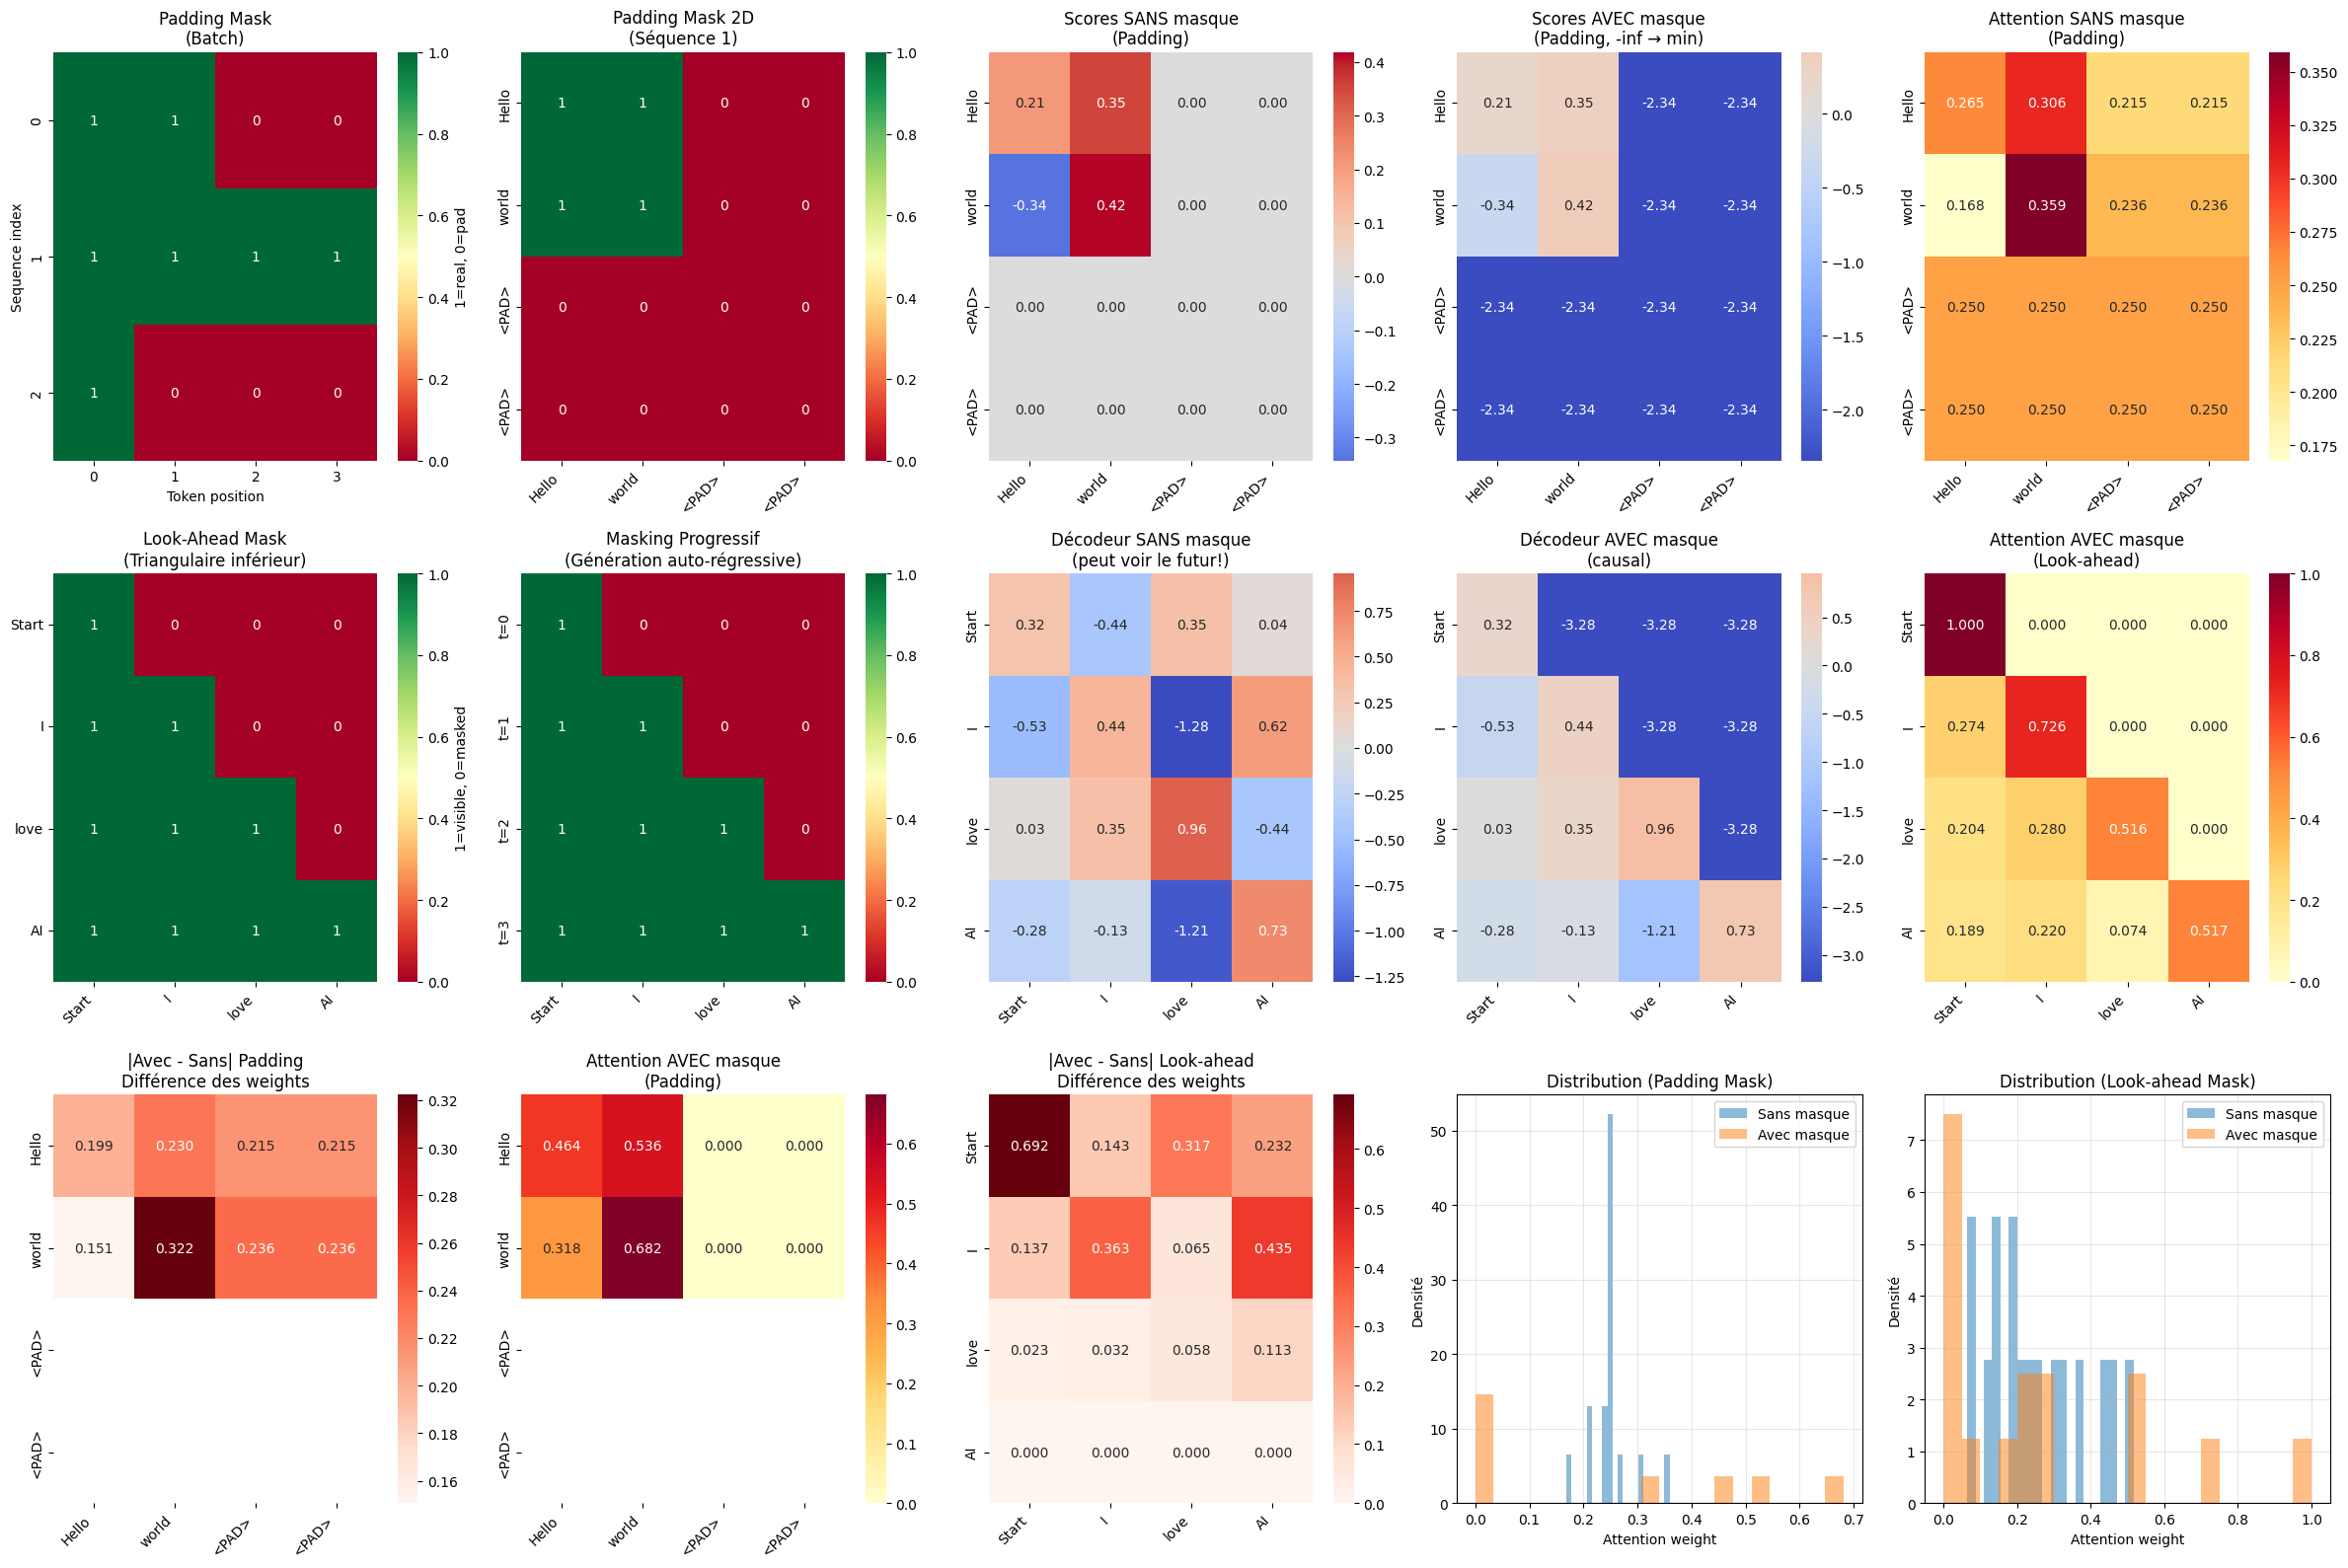


sequence 1: ['Hello', 'world', '<PAD>', '<PAD>']
Tokens réels: 2, Padding: 2
\ weights SANS masque:
[[0.26483214 0.30568497 0.21474144 0.21474144]
 [0.16784496 0.35928764 0.2364337  0.2364337 ]
 [0.25       0.25       0.25       0.25      ]
 [0.25       0.25       0.25       0.25      ]]

somme par ligne: [1. 1. 1. 1.]
\ weights AVEC masque:
[[0.46419667 0.53580333 0.         0.        ]
 [0.31841127 0.68158873 0.         0.        ]
 [       nan        nan        nan        nan]
 [       nan        nan        nan        nan]]

somme par ligne: [ 1.  1. nan nan]
\  tokens <PAD> (colonnes 2-3):
  SANS masque 1.9024
  AVEC masque: nan
\ décodeur: ['Start', 'I', 'love', 'AI']
\ weights SANS masque (peut voir le futur):
[[0.30803512 0.14312192 0.31730742 0.23153554]
 [0.13724752 0.36319731 0.06492591 0.43462926]
 [0.18065228 0.24874    0.45744394 0.11316378]
 [0.18859873 0.21977122 0.07446875 0.51716131]]

Atention weights AVEC masque (causal):
[[1.         0.         0.         0.       

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)

def layer_norm(x, eps=1e-6):
    mean = np.mean(x, axis=-1, keepdims=True)
    std = np.std(x, axis=-1, keepdims=True)
    return (x - mean) / (std + eps)

def create_padding_mask(sequence_lengths, max_length):
    
    batch_size = len(sequence_lengths)
    mask = np.zeros((batch_size, max_length))
    
    for i, length in enumerate(sequence_lengths):
        mask[i, :length] = 1
    
    return mask

def create_look_ahead_mask(size):
    
    mask = np.tril(np.ones((size, size)))
    return mask

def apply_mask_to_scores(scores, mask):
    if mask.ndim == 1:
        mask = mask[:, np.newaxis] * mask[np.newaxis, :]
    
    masked_scores = np.where(mask == 1, scores, -np.inf)
    return masked_scores

def compute_masked_attention(inputs, mask, embedding_dim, mask_type="padding"):
    
    np.random.seed(42)
    limit = np.sqrt(6.0 / (embedding_dim + embedding_dim))
    Wq = np.random.uniform(-limit, limit, (embedding_dim, embedding_dim))
    Wk = np.random.uniform(-limit, limit, (embedding_dim, embedding_dim))
    Wv = np.random.uniform(-limit, limit, (embedding_dim, embedding_dim))
    
    Q = np.dot(inputs, Wq)
    K = np.dot(inputs, Wk)
    V = np.dot(inputs, Wv)
    
    scores = np.dot(Q, K.T) / np.sqrt(K.shape[1])
    
    masked_scores = apply_mask_to_scores(scores, mask)
    
    attention_weights = softmax(masked_scores)
    
    output = np.dot(attention_weights, V)
    
    return scores, masked_scores, attention_weights, output

sequences = [
    ["Hello", "world", "<PAD>", "<PAD>"],
    ["Machine", "learning", "is", "amazing"],
    ["AI", "<PAD>", "<PAD>", "<PAD>"]
]
sequence_lengths = [2, 4, 1]
max_length = 4



for i, seq in enumerate(sequences):
    print(f"  Séquence {i+1} (longueur={sequence_lengths[i]}): {seq}")

padding_mask = create_padding_mask(sequence_lengths, max_length)

print(padding_mask)

embedding_dim = 4
np.random.seed(42)
embeddings_dict = {
    "Hello": np.random.randn(embedding_dim),
    "world": np.random.randn(embedding_dim),
    "Machine": np.random.randn(embedding_dim),
    "learning": np.random.randn(embedding_dim),
    "is": np.random.randn(embedding_dim),
    "amazing": np.random.randn(embedding_dim),
    "AI": np.random.randn(embedding_dim),
    "<PAD>": np.zeros(embedding_dim)  
}
seq_idx = 0
seq = sequences[seq_idx]
mask = padding_mask[seq_idx]


inputs = np.array([embeddings_dict[word] for word in seq])

scores_no_mask, _, weights_no_mask, output_no_mask = \
    compute_masked_attention(inputs, np.ones(max_length), embedding_dim)

scores_with_mask, masked_scores, weights_with_mask, output_with_mask = \
    compute_masked_attention(inputs, mask, embedding_dim)



decoder_seq = ["Start", "I", "love", "AI"]
print(f"\ décodeur: {decoder_seq}")

seq_length = len(decoder_seq)
look_ahead_mask = create_look_ahead_mask(seq_length)

print(f"\masque  look-ahead (1=peut voir, 0=ne peut pas voir):")
print(look_ahead_mask.astype(int))

decoder_inputs = np.array([embeddings_dict.get(word, np.random.randn(embedding_dim)) 
                           for word in decoder_seq])

scores_decoder_no_mask, _, weights_decoder_no_mask, output_decoder_no_mask = \
    compute_masked_attention(decoder_inputs, np.ones(seq_length), embedding_dim)

scores_decoder_with_mask, masked_scores_decoder, weights_decoder_with_mask, output_decoder_with_mask = \
    compute_masked_attention(decoder_inputs, look_ahead_mask, embedding_dim)

fig = plt.figure(figsize=(24, 16))


plt.subplot(3, 5, 1)
sns.heatmap(padding_mask, annot=True, fmt='.0f', cmap='RdYlGn', cbar_kws={'label': '1=real, 0=pad'})
plt.title('Padding Mask\n(Batch)')
plt.ylabel('Sequence index')
plt.xlabel('Token position')

plt.subplot(3, 5, 2)
mask_2d = mask[:, np.newaxis] * mask[np.newaxis, :]
sns.heatmap(mask_2d, annot=True, fmt='.0f', cmap='RdYlGn',
            xticklabels=seq, yticklabels=seq)
plt.title('Padding Mask 2D\n(Séquence 1)')
plt.xticks(rotation=45, ha='right')

plt.subplot(3, 5, 3)
sns.heatmap(scores_no_mask, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            xticklabels=seq, yticklabels=seq)
plt.title('Scores SANS masque\n(Padding)')
plt.xticks(rotation=45, ha='right')

plt.subplot(3, 5, 4)


scores_viz = np.where(np.isinf(masked_scores), np.min(scores_no_mask) - 2, masked_scores)
sns.heatmap(scores_viz, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            xticklabels=seq, yticklabels=seq)
plt.title('Scores AVEC masque\n(Padding, -inf → min)')
plt.xticks(rotation=45, ha='right')


plt.subplot(3, 5, 5)
sns.heatmap(weights_no_mask, annot=True, fmt='.3f', cmap='YlOrRd',
            xticklabels=seq, yticklabels=seq)
plt.title('Attention SANS masque\n(Padding)')
plt.xticks(rotation=45, ha='right')


plt.subplot(3, 5, 6)
sns.heatmap(look_ahead_mask, annot=True, fmt='.0f', cmap='RdYlGn',
            xticklabels=decoder_seq, yticklabels=decoder_seq,
            cbar_kws={'label': '1=visible, 0=masked'})
plt.title('Look-Ahead Mask\n(Triangulaire inférieur)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.subplot(3, 5, 7)
progressive_masks = []
for i in range(seq_length):
    row_mask = np.zeros(seq_length)
    row_mask[:i+1] = 1
    progressive_masks.append(row_mask)
progressive_masks = np.array(progressive_masks)
sns.heatmap(progressive_masks, annot=True, fmt='.0f', cmap='RdYlGn',
            xticklabels=decoder_seq, yticklabels=[f't={i}' for i in range(seq_length)])
plt.title('Masking Progressif\n(Génération auto-régressive)')
plt.xticks(rotation=45, ha='right')

plt.subplot(3, 5, 8)
sns.heatmap(scores_decoder_no_mask, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            xticklabels=decoder_seq, yticklabels=decoder_seq)
plt.title('Décodeur SANS masque\n(peut voir le futur!)')
plt.xticks(rotation=45, ha='right')


plt.subplot(3, 5, 9)
scores_decoder_viz = np.where(np.isinf(masked_scores_decoder), 
                               np.min(scores_decoder_no_mask) - 2, 
                               masked_scores_decoder)
sns.heatmap(scores_decoder_viz, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            xticklabels=decoder_seq, yticklabels=decoder_seq)
plt.title('Décodeur AVEC masque\n(causal)')
plt.xticks(rotation=45, ha='right')


plt.subplot(3, 5, 10)
sns.heatmap(weights_decoder_with_mask, annot=True, fmt='.3f', cmap='YlOrRd',
            xticklabels=decoder_seq, yticklabels=decoder_seq)
plt.title('Attention AVEC masque\n(Look-ahead)')
plt.xticks(rotation=45, ha='right')


plt.subplot(3, 5, 11)
diff_padding = np.abs(weights_with_mask - weights_no_mask)
sns.heatmap(diff_padding, annot=True, fmt='.3f', cmap='Reds',
            xticklabels=seq, yticklabels=seq)
plt.title('|Avec - Sans| Padding\nDifférence des weights')
plt.xticks(rotation=45, ha='right')


plt.subplot(3, 5, 12)
sns.heatmap(weights_with_mask, annot=True, fmt='.3f', cmap='YlOrRd',
            xticklabels=seq, yticklabels=seq)
plt.title('Attention AVEC masque\n(Padding)')
plt.xticks(rotation=45, ha='right')


plt.subplot(3, 5, 13)
diff_lookahead = np.abs(weights_decoder_with_mask - weights_decoder_no_mask)
sns.heatmap(diff_lookahead, annot=True, fmt='.3f', cmap='Reds',
            xticklabels=decoder_seq, yticklabels=decoder_seq)
plt.title('|Avec - Sans| Look-ahead\nDifférence des weights')
plt.xticks(rotation=45, ha='right')


plt.subplot(3, 5, 14)
plt.hist(weights_no_mask.flatten(), bins=20, alpha=0.5, label='Sans masque', density=True)
plt.hist(weights_with_mask.flatten(), bins=20, alpha=0.5, label='Avec masque', density=True)
plt.xlabel('Attention weight')
plt.ylabel('Densité')
plt.title('Distribution (Padding Mask)')
plt.legend()
plt.grid(True, alpha=0.3)


plt.subplot(3, 5, 15)
plt.hist(weights_decoder_no_mask.flatten(), bins=20, alpha=0.5, label='Sans masque', density=True)
plt.hist(weights_decoder_with_mask.flatten(), bins=20, alpha=0.5, label='Avec masque', density=True)
plt.xlabel('Attention weight')
plt.ylabel('Densité')
plt.title('Distribution (Look-ahead Mask)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()




print(f"\nsequence 1: {seq}")
print(f"Tokens réels: {sequence_lengths[seq_idx]}, Padding: {max_length - sequence_lengths[seq_idx]}")

print("\ weights SANS masque:")
print(weights_no_mask)
print(f"\nsomme par ligne: {np.sum(weights_no_mask, axis=1)}")

print("\ weights AVEC masque:")
print(weights_with_mask)
print(f"\nsomme par ligne: {np.sum(weights_with_mask, axis=1)}")

print(f"\  tokens <PAD> (colonnes 2-3):")
print(f"  SANS masque {np.sum(weights_no_mask[:, 2:]):.4f}")
print(f"  AVEC masque: {np.sum(weights_with_mask[:, 2:]):.4f}")


print(f"\ décodeur: {decoder_seq}")

print("\ weights SANS masque (peut voir le futur):")
print(weights_decoder_no_mask)

print("\nAtention weights AVEC masque (causal):")
print(weights_decoder_with_mask)

for i, word in enumerate(decoder_seq):
    future_attn_no_mask = np.sum(weights_decoder_no_mask[i, i+1:])
    future_attn_with_mask = np.sum(weights_decoder_with_mask[i, i+1:])
    print(f"  '{word}' (pos {i}):")
    print(f"    SANS masque: {future_attn_no_mask:.4f}")
    print(f"    AVEC masque: {future_attn_with_mask:.4f} (doit être 0)")



Masque de Remplissage (Padding Mask) :

        Problème SANS masque : Les mots réels perdaient de l'attention en la donnant aux <PAD> (jetons vides), ce qui diluait le signal.

        Résultat AVEC masque : En mettant les colonnes des <PAD> à zéro, l'Attention s'est concentrée plus fort sur les vrais mots (ex. le poids d'attention sur un mot est passé de 0.305 à 0.535). Le signal utile est renforcé.

Masque d'Anticipation (Look-ahead Mask) :

        But : Le modèle qui génère une phrase ne doit pas tricher en regardant les mots qu'il va écrire.

        Résultat : Le masque a créé une matrice triangulaire, confirmant que chaque mot regardait seulement les mots derrière lui 



    Post-LN:

          Avant la normalisation, le signal n'était pas controlé => il rends l'entrainement instable

    Pre-LN :

        il  offre une meilleure stabilité d’entraînement et des gradients plus réguliers.